# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd


from hydra import initialize, compose
from IPython.display import Audio
from itertools import product
from omegaconf import OmegaConf
from pathlib import Path
from PIL import Image
from torchmetrics.image import PeakSignalNoiseRatio
from torchvision.utils import make_grid, save_image
from tqdm import tqdm


from clearaudio.datasets.mel import Mel
from clearaudio.datasets.audio import AudioDatasetExtended
from clearaudio.models.guided_diffusion.script_util import (
    args_to_dict_if_present, 
    create_model_and_diffusion, 
    model_and_diffusion_defaults
)

/home/martorel/mambaforge/envs/odedit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with initialize(config_path="clearaudio/conf"):
    cfg = compose(config_name="config", overrides=["trainer=maestro_diffusion_scitas", "dataset=maestro_scitas_diffusion", "generator=diffusion_generator", "++dataset.ignore_lq_clips=False", "++dataset.fallback_generated_eqs=True", "++generator.sampler.use_ddim=False", "~generator.sampler.timestep_respacing", "++trainer.clip_duration=5"])
print(OmegaConf.to_yaml(cfg))

/tmp/ipykernel_1180096/2616216859.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="clearaudio/conf"):


dataset:
  low_quality_effect:
    train:
      mode: set
      effects:
      - name: '0'
        params:
        - equalizer 200 0.7 20
        - equalizer 450 20 30
        - treble -30 4000 1
      - name: '1'
        params:
        - bass -30 800 1
        - equalizer 2000 10 -30
        - equalizer 3000 0.7 25
      - name: '2'
        params:
        - bass -30 1200 1
        - equalizer 3000 10 -20
        - equalizer 5000 0.7 20
        - overdrive 10 10
      - name: '3'
        params:
        - bass -10 1000 1
        - equalizer 4000 10 -30
        - equalizer 5000 0.7 25
      - name: '4'
        params:
        - equalizer 2000 0.7 20
        - equalizer 750 10 20
        - treble -20 8500 1
      - name: '5'
        params:
        - equalizer 300 2 10
        - equalizer 950 10 -15
        - treble -30 8000 1
        - overdrive 5 7
      - name: '6'
        params:
        - equalizer 800 1 20
        - equalizer 1550 10 20
        - treble -20 8000 1
      - name: '

In [9]:
# create config
model_and_diffusion_args = model_and_diffusion_defaults()
model_and_diffusion_args.update(
    args_to_dict_if_present(cfg.trainer.model, model_and_diffusion_defaults().keys())
)
model_and_diffusion_args.update(
    args_to_dict_if_present(cfg.trainer.diffusion, model_and_diffusion_defaults().keys())
)
model_and_diffusion_args.update(
    args_to_dict_if_present(cfg.generator.sampler, model_and_diffusion_defaults().keys())
)
model, diffusion = create_model_and_diffusion(**model_and_diffusion_args)


# load checkpoint
device = "cuda:0"
model.load_state_dict(torch.load(Path(cfg.generator.checkpointpath).expanduser()))
model.to(device)
model.eval()

num_timesteps = diffusion.num_timesteps

In [10]:
dataset = AudioDatasetExtended(cfg)
dataset.eq_mode = "random"

mel = Mel(
    x_res=cfg.trainer.melspectrogram.x_res,
    y_res=cfg.trainer.melspectrogram.y_res,
    hop_length=cfg.trainer.melspectrogram.hop_length,
    sample_rate=cfg.trainer.melspectrogram.sample_rate,
    n_fft=cfg.trainer.melspectrogram.n_fft,
    n_iter=cfg.trainer.melspectrogram.griffin_lim_iters,
)

In [19]:
def to_image_range(img, flip_axes=True):
    if flip_axes:
        return np.transpose(
            np.clip(((img + 1) * 127.5), 0, 255).astype(np.uint8),
            (1, 2, 0)
        )
    else:
        return np.clip(((img + 1) * 127.5), 0, 255).astype(np.uint8)
    
def set_seed(dataset, seed=0):
    dataset.seed_rng_generator()
    np.random.seed(seed)
    
def imshow(img, title="", show=True, transpose=True):
    img = torch.tensor(img)
    if len(img.shape) == 3:
        img = img.unsqueeze(0)
    
    img = img.to("cpu")
    img = img.permute(1, 2, 0, 3)
    img = img.reshape(img.shape[0], img.shape[1], -1)
    img = img / 2 + 0.5     # unnormalize
    img = torch.clamp(img, min=0., max=1.)
    npimg = img.numpy()
    
    transposed = npimg
    if transpose:
        transposed = np.transpose(npimg, (1, 2, 0))
    
    if show:
        plt.imshow(transposed, cmap="gray")
        plt.title(title)
        plt.show()
        
    return transposed
    
def play_audio(img_tensor, label="Audio", mel=mel):
    img = Image.fromarray(to_image_range(img_tensor.cpu().detach().numpy())[..., 0], mode="L")
    result_audio = mel.image_to_audio(img)
    display(label)
    display(Audio(data=result_audio, rate=mel.get_sample_rate()))
    
def to_audio(img_tensor, label="Audio", mel=mel):
    img = Image.fromarray(to_image_range(img_tensor.cpu().detach().numpy())[..., 0], mode="L")
    result_audio = mel.image_to_audio(img)
    return result_audio

def plot_samples_grid(samples_tensor, nrow=4, title="", rows_texts=None, cols_texts=None, figsize=(10, 10)):
    """
    Plots an image with title, xlabel, ylabel, and additional texts.

    :param tensor of images: torch.tensor of images (stacked along the batch dimension).
    :param title: Title text to be displayed above the image.
    :param nrow: How many images per row to display.
    :param rows_texts: Labels for the rows.
    :param rows_texts: Labels for the cols.
    """
    # Load and display the image
    
    img = make_grid(samples_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    
    # Add title, xlabel, and ylabel if provided
    if title:
        plt.title(title, pad=40 if cols_texts is not None else 0)

    # Add additional texts if provided
    if rows_texts:
        img_height = samples_tensor.shape[-2]
        texts = [(img_height // 2 + img_height * i, text) for i, text in enumerate(rows_texts)]
        for y, text in texts:
            plt.text(-20, y, text, fontsize=10, ha='right', va='center')
        
    if cols_texts:
        img_width = samples_tensor.shape[-1]
        texts = [(img_width // 2 + img_width * i, text) for i, text in enumerate(cols_texts)]
        for x, text in texts:
            plt.text(x, -20, text, fontsize=10, ha='center', va='bottom')
            

    # Show the plot
    plt.axis("off")
    plt.show()

## Plot Diffusion Alphas

In [ ]:
betas = diffusion.betas
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
plt.plot(alphas_cumprod)

# Maestro Dataset

In [ ]:
# display dataset's first image
from PIL import Image
import numpy as np

set_seed(dataset, 0)

hq_sample, lq_sample = dataset[0]

imshow(hq_sample, "HQ Sample")
imshow(lq_sample, "LQ Sample");

In [ ]:
from itertools import chain
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

set_seed(dataset, 0)

indices = np.random.choice(len(dataset), 20)
samples = [dataset[i] for i in indices]
samples_unpacked = [x[0] for x in samples] + [x[1] for x in samples]

hq_samples = [torch.tensor(x[0]) for x in samples]
lq_samples = [torch.tensor(x[1]) for x in samples]

samples_tensor = torch.tensor([imshow(x, show=False, transpose=False) for x in samples_unpacked])

plot_samples_grid(
    samples_tensor,
    title='Samples Visualization',
    rows_texts=['HQ Samples', 'LQ Samples'],
    cols_texts=[f"Sample {i}" for i in indices],
    figsize=(10, 10)
)

# SDEdit

In [197]:
def extract(a, t, x_shape):
    """Extract coefficients from a based on t and reshape to make it
    broadcastable with x_shape."""
    bs, = t.shape
    assert x_shape[0] == bs
    out = torch.gather(torch.tensor(a, dtype=torch.float, device=t.device), 0, t.long())
    assert out.shape == (bs,)
    out = out.reshape((bs,) + (1,) * (len(x_shape) - 1))
    return out


def image_editing_denoising_step_flexible_mask(x, t, *,
                                               model,
                                               logvar,
                                               betas):
    """
    Sample from p(x_{t-1} | x_t)
    """
    alphas = 1.0 - betas
    alphas_cumprod = alphas.cumprod(dim=0)

    model_output = model(x, t)[:, 0, ...]
    weighted_score = betas / torch.sqrt(1 - alphas_cumprod)
    mean = extract(1 / torch.sqrt(alphas), t, x.shape) * (x - extract(weighted_score, t, x.shape) * model_output)

    logvar = extract(logvar, t, x.shape)
    noise = torch.randn_like(x)
    mask = 1 - (t == 0).float()
    mask = mask.reshape((x.shape[0],) + (1,) * (len(x.shape) - 1))
    sample = mean + mask * torch.exp(0.5 * logvar) * noise
    sample = sample.float()
    return sample

def SDEditing(img_tensor, betas, logvar, model, sample_step, total_noise_levels, n=4, device='cuda', show=True):
    if show:
        print("Start sampling")
    
    latent_codes = []

    with torch.no_grad():
        img = img_tensor.to(device)
        img = img_tensor / 2 + 0.5
        img = img.to(device)
        if len(img.shape) < 4:
            img = img.unsqueeze(dim=0)
            
            img = img.repeat(n, 1, 1, 1)
        else:
            img = img
        mask = torch.zeros_like(img[0])
        mask = mask.to(device)
        x0 = img
        x0 = (x0 - 0.5) * 2.
        
        if show:
            imshow(x0, title="Initial input")

        for it in range(sample_step):
            e = torch.randn_like(x0)
            a = (1 - betas).cumprod(dim=0).to(device)
            x = x0 * a[total_noise_levels - 1].sqrt() + e * (1.0 - a[total_noise_levels - 1]).sqrt()
            latent_codes.append(x)
            
            if show:
                imshow(x, title="Perturb with SDE")

            with tqdm(total=total_noise_levels, desc="Iteration {}".format(it), disable=(not show)) as progress_bar:
                for i in reversed(range(total_noise_levels)):
                    # t = torch.ones_like(x) * i
                    t = (torch.ones(x.shape[0]) * i).to(device)
                    x_ = image_editing_denoising_step_flexible_mask(x, t=t, model=model,
                                                                    logvar=logvar,
                                                                    betas=betas)
                    x = x0 * a[i].sqrt() + e * (1.0 - a[i]).sqrt()
                    x[:, (mask != 1.)] = x_[:, (mask != 1.)]
                    # added intermediate step vis
                    # if (i - 99) % 100 == 0:
                    #     imshow(x, title="Iteration {}, t={}".format(it, i))
                    progress_bar.update(1)
                    latent_codes.append(x)

            x0[:, (mask != 1.)] = x[:, (mask != 1.)]
            
            if show:
                imshow(x)
    return x, latent_codes

In [ ]:
list_images = lq_samples
list_enhanced_sde = {}


sample_step = 1
betas = torch.tensor(diffusion.betas)
num_timesteps = diffusion.num_timesteps
logvar = np.log(np.maximum(diffusion.posterior_variance, 1e-20))


for total_noise_levels in range(100,700,100):
    list_enhanced_sde[total_noise_levels] = []
    for img in [sas]:
        new_img_tensor = img.to(device)
        sde_enhanced = SDEditing(new_img_tensor, betas, logvar, model, sample_step, total_noise_levels, n=1)
        list_enhanced_sde[total_noise_levels].append(sde_enhanced[0])

In [184]:
for x in chain.from_iterable(list_enhanced_sde.values()):
    print(x.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


In [190]:
sdedit_sutus = list(chain.from_iterable(list_enhanced_sde.values()))[0]

In [ ]:
imshow(sdedit_sutus)
play_audio(sus)

In [ ]:
for img in chain.from_iterable(list_enhanced_sde.values()):
    play_audio(img.squeeze(dim=0))

In [ ]:
sdedit_steps = list(list_enhanced_sde.keys())
sdedit_results = list(chain.from_iterable(list_enhanced_sde.values()))

samples_tensor = torch.tensor([imshow(x, show=False, transpose=False) for x in samples_unpacked + sdedit_results])

plot_samples_grid(
    samples_tensor,
    title='Samples Visualization',
    rows_texts=['HQ Samples', 'LQ Samples'] + [f"SDEdit (steps={x})" for x in sdedit_steps],
    cols_texts=[f"Sample {i}" for i in indices],
    figsize=(20, 10)
)

# ODEdit Stability

## Score-based generation

In [198]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    try:
        res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    except:
        res = arr.to(device=timesteps.device)[timesteps].float()
    
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


@torch.no_grad()
def langevin_sampling(inputs, model, t, t_prev, alphas_cumprod, steps = 100, epsilon = 10e-5,min_variance = 1e-4, 
                      device = device, denoising_step = True, clip_prev = False, clip_now = False, power = 0.5):
    t = torch.tensor([t] * inputs.shape[0], device=device)  
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    std = torch.sqrt(variance)
    std_epsilon = []
    mean_epsilon = []
    if t_prev is not None:
        t_prev = torch.tensor([t_prev] * inputs.shape[0], device=device)        
        mean_coef_t_prev = torch.sqrt(_extract_into_tensor(alphas_cumprod, t_prev , inputs.shape))
        variance_t_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_t_prev)
        noise_estimate_t_prev = model(inputs, t_prev)[:, 0, ...]
        x0_t_1 = (inputs - std_prev * noise_estimate_t_prev)/mean_coef_t_prev
        if clip_prev:
            x0_t_1 = x0_t_1.clamp(-1,1)
        inputs = inputs + x0_t_1 * (mean_coef_t - mean_coef_t_prev)
    inputs = inputs.to(device)    
    model = model.to(device)
    alpha_coef = epsilon * (variance/min_variance)
    # print(f" alpha_coef at {t.cpu().float().mean()}: {alpha_coef}")
    with torch.no_grad():
        for i in range(steps):
            noise_estimate = model(inputs, t)[:, 0, ...] # output has 2 channels, noise estimate and sigma
            if clip_now:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = x0_t.clamp(-1,1)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            std_epsilon.append(noise_estimate[0].cpu().std().item())
            mean_epsilon.append(noise_estimate[0].cpu().mean().item())
            score = - noise_estimate / std
            noise = torch.randn(inputs.shape).to(device)
            inputs = (inputs + alpha_coef * score) + torch.pow(2*alpha_coef, power) * noise
        if denoising_step:
            noise_estimate = model(inputs, t)[:, 0, ...]
            score = - noise_estimate / std
            inputs = (inputs + alpha_coef * score) 
    return inputs, alpha_coef, std_epsilon, mean_epsilon

def score_generation(inputs, model, steps, alphas_cumprod, epsilon, device, num_timesteps, number_of_scale = 10):
    list_alpha_coef = []
    t_valid = [999,750,600,500,450,400,360,320,280,240,200,160,130,110,90,64,36,20,5,0]
    t_min_var = torch.tensor([t_valid[-1]], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    print("min_variance",min_variance)
    list_of_evolution = []
    list_of_evolution.append(inputs[0].cpu())
    t_prev = None
    for t in tqdm(t_valid):
        inputs, alpha_coef, std_epsilon, mean_epsilon = langevin_sampling(inputs, model, t, t_prev, alphas_cumprod, steps = steps, epsilon = epsilon,min_variance = min_variance, device = device)
        
        if t % 1 ==0:
            list_of_evolution.append(inputs[0].cpu())
            list_alpha_coef.append(alpha_coef.cpu().mean().item())
            plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
            plt.show()
        t_prev = t
    plt.figure(figsize=[30,30])
    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    plt.show()
    plt.plot(np.array(list_alpha_coef))
    plt.show()
    return list_of_evolution

In [11]:
number_of_sample = 1
shape = [number_of_sample, 1, 256, 256]
random_seed = torch.randn(shape).to(device)

In [ ]:
list_of_evolution = score_generation(random_seed, model, 100, alphas_cumprod, epsilon=1e-5, device=device, num_timesteps=num_timesteps)
play_audio(list_of_evolution[-1], "Score-based generation")

## DDIM Inversion

In [253]:
@torch.no_grad()
def ddim_step(inputs, model, t, alphas_cumprod, clip_denoised = False, clip_value = 1, sigma = 0, 
              number_of_timesteps = num_timesteps, device = device, forward = True, number_of_sample = 1):
    model = model.to(device)
    if t > 0 and forward:
        t_prev = torch.tensor([t-1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    elif t < number_of_timesteps - 1:
        t_prev = torch.tensor([t+1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    t = torch.tensor([t] * inputs.shape[0], device=device)
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    std = torch.sqrt(variance)
    noise_estimate = model(inputs, t)[:, 0, ...]
    std_epsilon = noise_estimate[0].cpu().std().item()
    mean_epsilon = noise_estimate[0].cpu().mean().item()
    if clip_denoised:
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
        x0_t = x0_t.clamp(-1,1)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    if sigma > 0:
        sigma_t = sigma * torch.sqrt((variance_prev)/(variance)) * torch.sqrt(1 - (1-variance)/ (1-variance_prev))
    else:
        sigma_t = 0.
    noise= torch.randn_like(inputs)
    x_prev = torch.sqrt(1-variance_prev) / torch.sqrt(1-variance) * ((inputs - std * noise_estimate)) + torch.sqrt(variance_prev - sigma_t**2)  * noise_estimate + sigma_t * noise
    return x_prev, std_epsilon, mean_epsilon

def encoding_ddim(img_tensor, model, num_timesteps, alphas_cumprod, device=device, show_intermediate=True, show_final=True):
    inputs = img_tensor.unsqueeze(0).to(device)
    list_of_evolution = []
    list_of_evolution_t = []
    list_std_encoding = []
    list_mean_encoding = []
    latent_codes = []
    with torch.no_grad():
        latent_codes.append(inputs.cpu())
        for t in range(0, num_timesteps-1):
            inputs, std_eps, mean_eps = ddim_step(inputs, model, t, alphas_cumprod, sigma = 0., device = device, forward=False)
            latent_codes.append(inputs.cpu())
            list_std_encoding.append(std_eps)
            list_mean_encoding.append(mean_eps)
            if t % 100 == 0:
                list_of_evolution.append(inputs[0].cpu())
                list_of_evolution_t.append(t)
                
                if show_intermediate:
                    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                    plt.show()
        list_of_evolution.append(inputs[0].cpu())
        list_of_evolution_t.append(t)

    if show_final:
        plt.figure(figsize=[20,20])
        plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
        plt.show()
    latent_code = inputs
    
    return latent_code, latent_codes, list_of_evolution, list_of_evolution_t, list_std_encoding, list_mean_encoding

In [ ]:
encoding_ddim_results = []

for lq in lq_samples:
    encoding_ddim_results.append(encoding_ddim(lq, model, num_timesteps, alphas_cumprod, show_intermediate=False))

In [233]:
def plot_timeseries(time_series, ax, label):
    mean_data = np.mean(time_series, axis=0)
    std_deviation = np.std(time_series, axis=0)

    # Create a time array (replace this with your time values if available)
    time = np.arange(len(mean_data))
    
    ax.plot(time, mean_data, label=f"{label}")
    ax.fill_between(time, mean_data - std_deviation, mean_data + std_deviation, alpha=0.2)
    ax.set_xlabel("Step")

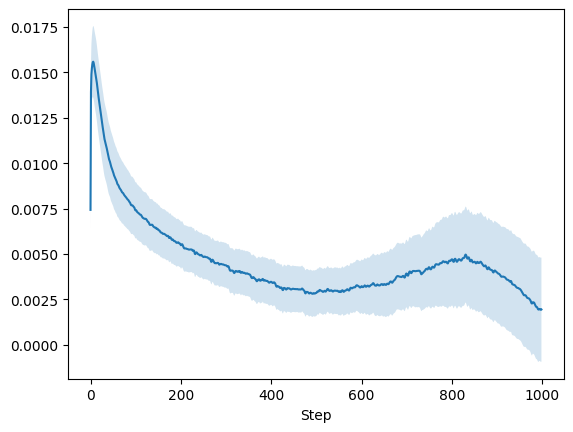

In [212]:
ax = plt.subplot()
plot_timeseries(mean_enc_mean, ax, "")

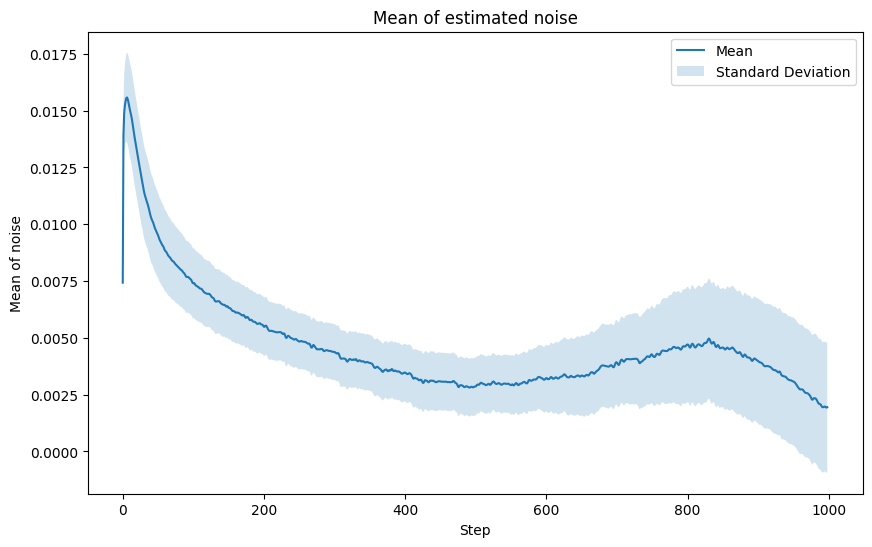

In [202]:
mean_enc_mean = []

for i, res in enumerate(encoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_encoding,
        list_mean_encoding
    ) = res
    
    mean_enc_mean.append(list_mean_encoding)
    
import matplotlib.pyplot as plt
import numpy as np

# Sample data: a list of time series (replace this with your data)
time_series = mean_enc_mean

# Calculate the mean and standard deviation across time series
mean_data = np.mean(time_series, axis=0)
std_deviation = np.std(time_series, axis=0)

# Create a time array (replace this with your time values if available)
time = np.arange(len(mean_data))

# Plot the mean with a shaded standard deviation band
plt.figure(figsize=(10, 6))
plt.plot(time, mean_data, label='Mean')
plt.fill_between(time, mean_data - std_deviation, mean_data + std_deviation, alpha=0.2, label='Standard Deviation')

plt.xlabel("Step")
plt.ylabel('Mean of noise')
plt.title("Mean of estimated noise")
plt.legend()
plt.show()

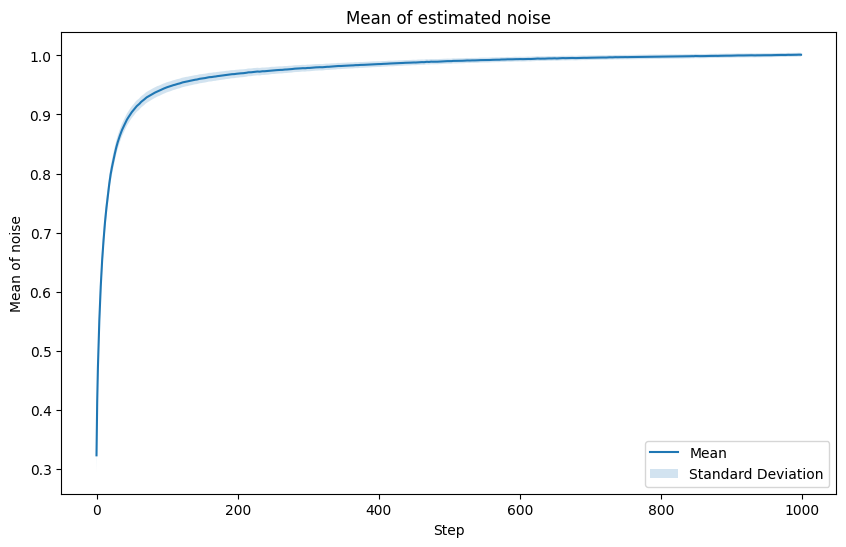

In [203]:
std_enc_mean = []

for i, res in enumerate(encoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_encoding,
        list_mean_encoding
    ) = res
    
    std_enc_mean.append(list_std_encoding)

import matplotlib.pyplot as plt
import numpy as np

# Sample data: a list of time series (replace this with your data)
time_series = std_enc_mean

# Calculate the mean and standard deviation across time series
mean_data = np.mean(time_series, axis=0)
std_deviation = np.std(time_series, axis=0)

# Create a time array (replace this with your time values if available)
time = np.arange(len(mean_data))

# Plot the mean with a shaded standard deviation band
plt.figure(figsize=(10, 6))
plt.plot(time, mean_data, label='Mean')
plt.fill_between(time, mean_data - std_deviation, mean_data + std_deviation, alpha=0.2, label='Standard Deviation')

plt.xlabel("Step")
plt.ylabel('Mean of noise')
plt.title("Mean of estimated noise")
plt.legend()
plt.show()

In [23]:
def decoding_ddim(latent_code, model, num_timesteps, alphas_cumprod, device=device, show_intermediate=True):
    inputs = latent_code.to(device)
    list_of_evolution = []
    list_of_evolution_t = []
    list_std_decoding = []
    list_mean_decoding = []
    decoded_latents = []
    # steps = 100
    # epsilon = 1e-8
    t_min_var = torch.tensor([1], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    with torch.no_grad():
        decoded_latents.append(inputs)
        for t in list(range(0, num_timesteps-1))[::-1]:
            inputs, std_eps, mean_eps = ddim_step(inputs, model, t, alphas_cumprod, sigma = 0., device = device, forward=True)
            list_std_decoding.append(std_eps)
            list_mean_decoding.append(mean_eps)
            decoded_latents.append(inputs)
            if t % 100 ==0:
                list_of_evolution.append(inputs[0].cpu())
                list_of_evolution_t.append(t)
                
                if show_intermediate:
                    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                    plt.show()

        list_of_evolution.append(inputs[0].cpu())
        list_of_evolution_t.append(t)

    plt.figure(figsize=[20,20])
    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    plt.show()
    
    return inputs, decoded_latents, list_of_evolution, list_of_evolution_t, list_std_decoding, list_mean_decoding

In [ ]:
decoding_ddim_results = []

for x in encoding_ddim_results:
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_encoding,
        list_mean_encoding
    ) = x
    
    decoding_ddim_results.append(decoding_ddim(latent_code, model, num_timesteps, alphas_cumprod))

In [ ]:
rnd_encoding_list = []
rnd_decoding_list = []

shape = [number_of_sample, 1, 256, 256]

for i in range(20):
    rnd = torch.randn(shape).to(device)
    rnd_decoding = decoding_ddim(rnd, model, num_timesteps, alphas_cumprod, show_intermediate=False)
    rnd_encoding = encoding_ddim(rnd_decoding[0].squeeze(dim=0), model, num_timesteps, alphas_cumprod, show_intermediate=False)
    
    rnd_encoding_list.append(rnd_encoding)
    rnd_decoding_list.append(rnd_decoding)

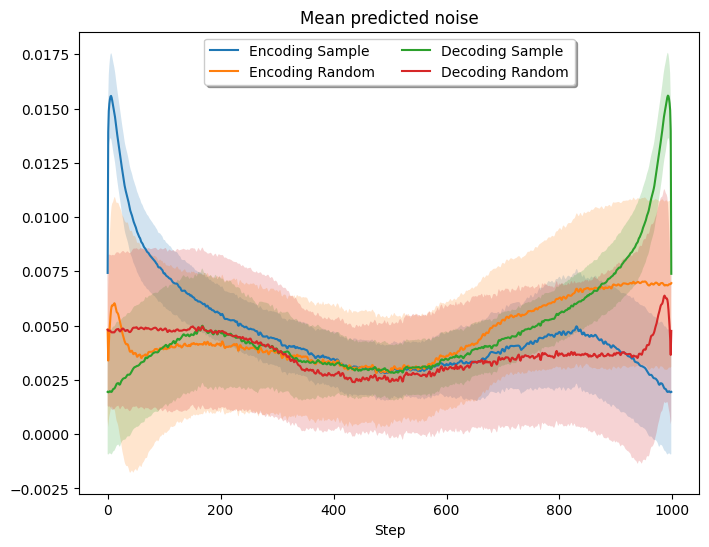

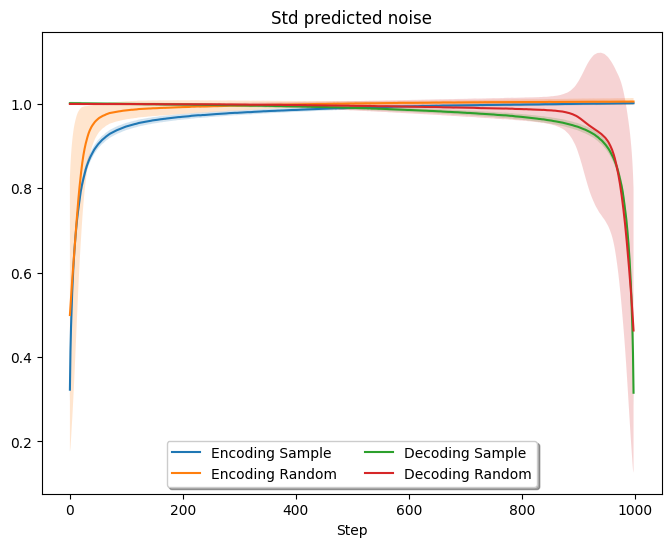

In [244]:
mean_enc_mean = []
std_enc_mean = []
mean_dec_mean = []
std_dec_mean = []

mean_enc_mean_rnd = []
std_enc_mean_rnd = []
mean_dec_mean_rnd = []
std_dec_mean_rnd = []

for i, res in enumerate(encoding_ddim_results):
    (_, _, _, _, list_std_encoding, list_mean_encoding) = res
    mean_enc_mean.append(list_mean_encoding)
    std_enc_mean.append(list_std_encoding)
    
for i, res in enumerate(decoding_ddim_results):
    (_, _, _, _, list_std_decoding, list_mean_decoding) = res
    mean_dec_mean.append(list_mean_decoding)
    std_dec_mean.append(list_std_decoding)
    
for i, res in enumerate(rnd_encoding_list):
    (_, _, _, _, list_std_encoding, list_mean_encoding) = res
    mean_enc_mean_rnd.append(list_mean_encoding)
    std_enc_mean_rnd.append(list_std_encoding)
    
for i, res in enumerate(rnd_decoding_list):
    (_, _, _, _, list_std_encoding, list_mean_encoding) = res
    mean_dec_mean_rnd.append(list_mean_encoding)
    std_dec_mean_rnd.append(list_std_encoding)

fig, ax = plt.subplots(figsize=(8, 6))
plot_timeseries(mean_enc_mean, ax, "Encoding Sample")
plot_timeseries(mean_enc_mean_rnd, ax, "Encoding Random")
plot_timeseries(mean_dec_mean, ax, "Decoding Sample")
plot_timeseries(mean_dec_mean_rnd, ax, "Decoding Random")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
          ncol=2, fancybox=True, shadow=True)
ax.set_title("Mean predicted noise")
plt.plot();

fig, ax = plt.subplots(figsize=(8, 6))
plot_timeseries(std_enc_mean, ax, "Encoding Sample")
plot_timeseries(std_enc_mean_rnd, ax, "Encoding Random")
plot_timeseries(std_dec_mean, ax, "Decoding Sample")
plot_timeseries(std_dec_mean_rnd, ax, "Decoding Random")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
          ncol=2, fancybox=True, shadow=True)
ax.set_title("Std predicted noise")
plt.plot();

In [ ]:
for i, res in enumerate(encoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_encoding,
        list_mean_encoding
    ) = res
    
    plt.plot(list_mean_encoding, label=f"Sample {indices[i]} - encoding")
    
for i, res in enumerate(decoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_decoding,
        list_mean_decoding
    ) = res
    
    plt.plot(list_mean_decoding, label=f"Sample {indices[i]} - decoding")


plt.plot(np.array(rnd_decoding[-1]), label="Random - decoding")
plt.plot(np.array(rnd_encoding[-1]), label="Random - encoding")
    
plt.title("Mean of estimated noise")
plt.xlabel("Step")
plt.legend();

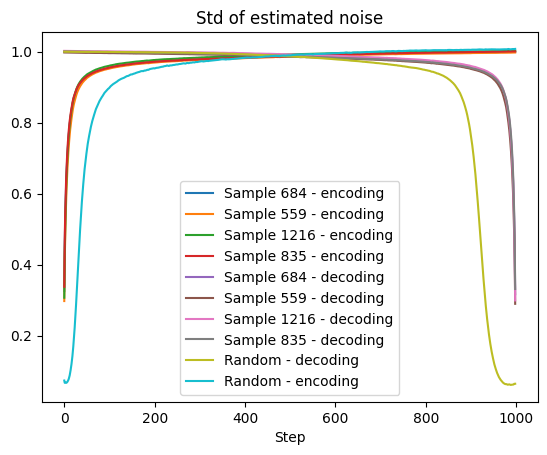

In [32]:
for i, res in enumerate(encoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_encoding,
        list_mean_encoding
    ) = res
    
    plt.plot(list_std_encoding, label=f"Sample {indices[i]} - encoding")
    
for i, res in enumerate(decoding_ddim_results):
    (
        latent_code,
        latent_codes,
        list_of_evolution,
        list_of_evolution_t,
        list_std_decoding,
        list_mean_decoding
    ) = res
    
    plt.plot(list_std_decoding, label=f"Sample {indices[i]} - decoding")


plt.plot(np.array(rnd_decoding[-2]), label="Random - decoding")
plt.plot(np.array(rnd_encoding[-2]), label="Random - encoding")
    
plt.title("Std of estimated noise")
plt.xlabel("Step")
plt.legend();

# ODEdit

In [241]:
def ODEditing(latent_codes, model, t_valid, alphas_cumprod, steps=10, epsilon=1e-7, number_of_sample=1, power=0.5, show_intermediate=True, show_final=True):
    list_of_std_eps_ddim = []
    list_of_stds_eps_langevin = []
    list_of_mean_eps_langevin = []
    list_of_mean_eps_ddim = []
    langevin_decoded_codes = []

#     inputs = latent_code.repeat(number_of_sample,1,1,1)
    list_of_evolution_reverse = []
    #     t_valid = list(range(1,1000,100))[::-1]

    list_alpha = []
#     list_distances = []
#     list_distances_decoded = []
    #     reverse_decoded_latent = decoded_latents[::-1]
    t_min_var = torch.tensor([1], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    with torch.no_grad():
        inputs = latent_codes[np.max(t_valid)].repeat(number_of_sample,1,1,1)
        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
        for t in range(1,np.max(t_valid)+1)[::-1]:
            if t in t_valid:
                inputs, alpha_coef, list_of_stds, list_of_means = langevin_sampling(inputs, model, t, t, alphas_cumprod, steps = steps, epsilon = epsilon,
                                       min_variance = min_variance, clip_prev = False, clip_now = False, device = device, power = power)
                list_alpha.append(alpha_coef)
                list_of_stds_eps_langevin.append(list_of_stds)
                list_of_mean_eps_langevin.append(list_of_means)

                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())
#             list_distances.append((((latent_codes[t].repeat(number_of_sample, 1,1,1))-inputs)**2).mean().item())
#             list_distances_decoded.append((((reverse_decoded_latent[t].repeat(number_of_sample, 1,1,1))-inputs)**2).mean().item())
            langevin_decoded_codes.append(inputs)
            inputs, std_epsilon, mean_epsilon = ddim_step(inputs, model, t, alphas_cumprod, sigma = 0., device = device, forward=True, number_of_sample = number_of_sample)
            list_of_std_eps_ddim.append(std_epsilon)
            list_of_mean_eps_ddim.append(mean_epsilon)
            if t % 50 ==0:
                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())

                    # list_of_evolution_reverse.append(inputs[1].cpu())
            if t % 100 ==0 and show_intermediate:
                plt.imshow(make_grid(list_of_evolution_reverse).permute(1,2,0).cpu()/2+0.5)
                plt.show()
        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
        # list_of_evolution_reverse.append(inputs[1].cpu())
        
    if show_final:
        plt.figure(figsize=[10,10])
        plt.imshow(make_grid(list_of_evolution_reverse).permute(1,2,0).cpu()/2+0.5)
        plt.show()
    
    return inputs, list_of_evolution_reverse, list_of_mean_eps_ddim, list_of_std_eps_ddim, list_of_mean_eps_langevin, list_of_stds_eps_langevin, langevin_decoded_codes

In [170]:
steps = 50
epsilons = [1e-5, 1e-6, 5e-7, 1e-7]
epsilons = [2e-7]
total_noise_levels = range(500,1000,1000)
number_of_sample = 1
power = 0.9

In [ ]:
list_enhanced_ode = {}
results_odedit = []
list_images = lq_samples

for noise, epsilon in product(total_noise_levels, epsilons):
    list_enhanced_ode[(noise, epsilon)] = []
    for i, img in enumerate(list_images[2:3]):
        print(f"ODEdit - {noise} steps - {epsilon} epsilon")
        
        result = ODEditing(
            encoding_ddim_results[i][1],
            model,
            list(range(10,noise,50))[::-1],
            alphas_cumprod,
            steps=steps,
            epsilon=epsilon,
            number_of_sample=number_of_sample,
            power=power,
            show_intermediate=True
        )
        
        list_enhanced_ode[(noise, epsilon)].append(result[0])

In [ ]:
(_, _, f_evolution, _, _, _) = encoding_ddim_results[0]
evolution = result[1]


plt.figure(figsize=[20,20])
plt.imshow(make_grid(f_evolution[:noise // 100 + 1] + evolution[1:]).permute(1,2,0).cpu()/2+0.5);

In [ ]:
imshow(hq_samples[2]);

In [ ]:
play_audio(hq_samples[2])
play_audio(lq_samples[2])
play_audio(result[0].squeeze(dim=0))

/tmp/ipykernel_1180096/368442081.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


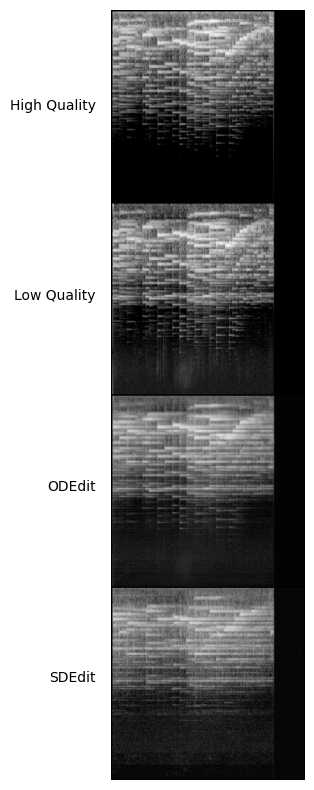

In [195]:
plot_samples_grid(
    torch.tensor([imshow(x, show=False, transpose=False) for x in [sus, sas, asdf, sdedit_sutus]]),
    nrow=1,
#     =['HQ Samples', 'LQ Samples'],
    rows_texts=["High Quality", "Low Quality", "ODEdit", "SDEdit"],
    figsize=(5, 10)
)

In [ ]:
odedit_steps = list(list_enhanced_ode.keys())
odedit_results = list(chain.from_iterable(list_enhanced_ode.values()))

samples_tensor = torch.tensor([imshow(x, show=False, transpose=False) for x in samples_unpacked + odedit_results])

plot_samples_grid(
    samples_tensor,
    title='Samples Visualization',
    rows_texts=['HQ Samples', 'LQ Samples'] + [f"ODEdit (steps={x[0]}, epsilon={x[1]})" for x in odedit_steps],
    cols_texts=[f"Sample {i}" for i in indices],
    figsize=(20, 10)
)

# ODEdit Analysis

In [ ]:
odedit_results = []

for i in range(20):
    odedit_result = ODEditing(
        encoding_ddim_results[i][1],
        model,
        list(range(1,1000,100))[::-1],
        alphas_cumprod,
        steps=steps,
        epsilon=1e-7,
        number_of_sample=number_of_sample,
        power=power,
        show_intermediate=False
    )
    
    odedit_results.append(odedit_result)

In [ ]:
hq_encodings = []

for i in tqdm(range(20)):
    enc = encoding_ddim(hq_samples[i], model, num_timesteps, alphas_cumprod, show_intermediate=False)
    hq_encodings.append(enc)

In [ ]:
sdedit_results = []

for i in tqdm(range(20)):
    sdedit_result = SDEditing(lq_samples[i].to(device), betas, logvar, model, sample_step, 700, n=1, show=False)
    sdedit_results.append(sdedit_result)

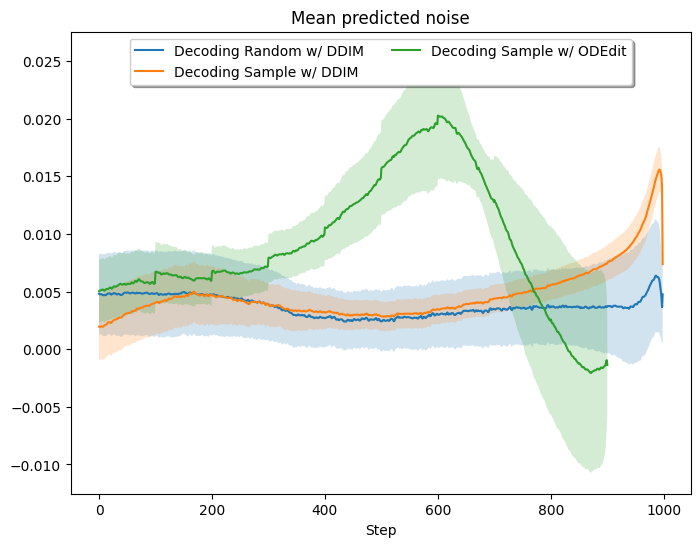

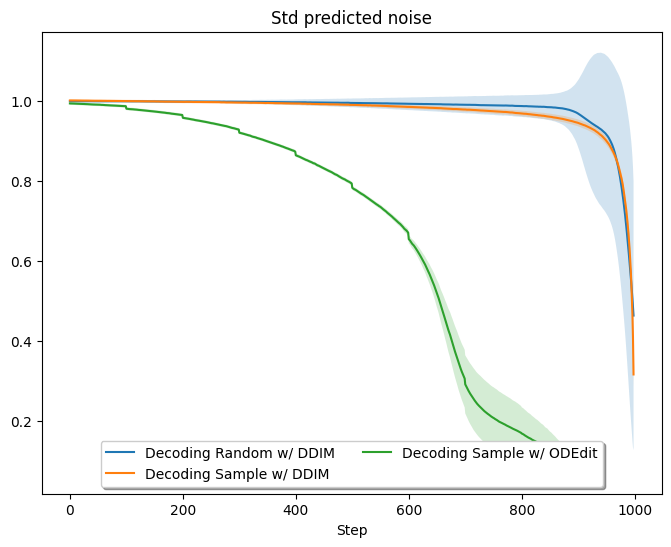

In [249]:
mean_dec_mean_odedit = []
std_dec_mean_odedit = []

for i, res in enumerate(odedit_results):
    (_, _, list_of_mean_eps_ddim, list_of_std_eps_ddim, _, _, _) = res
    mean_dec_mean_odedit.append(list_of_mean_eps_ddim)
    std_dec_mean_odedit.append(list_of_std_eps_ddim)
    
fig, ax = plt.subplots(figsize=(8, 6))
plot_timeseries(mean_dec_mean_rnd, ax, "Decoding Random w/ DDIM")
plot_timeseries(mean_dec_mean, ax, "Decoding Sample w/ DDIM")
plot_timeseries(mean_dec_mean_odedit, ax, "Decoding Sample w/ ODEdit")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.),
          ncol=2, fancybox=True, shadow=True)
ax.set_title("Mean predicted noise")
plt.plot();

fig, ax = plt.subplots(figsize=(8, 6))
plot_timeseries(std_dec_mean_rnd, ax, "Decoding Random w/ DDIM")
plot_timeseries(std_dec_mean, ax, "Decoding Sample w/ DDIM")
plot_timeseries(std_dec_mean_odedit, ax, "Decoding Sample w/ ODEdit")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 0),
          ncol=2, fancybox=True, shadow=True)
ax.set_title("Std predicted noise")
plt.plot();

In [ ]:
(
    _,
    list_of_evolution_reverse,
    list_of_mean_eps_ddim,
    list_of_std_eps_ddim,
    list_of_mean_eps_langevin,
    list_of_stds_eps_langevin,
    langevin_decoded_codes
) = odedit_result

(_, decoded_latent_codes, list_of_evolution, list_of_evolution_t, list_std_decoding, list_mean_decoding) = decoding_ddim_results[0]
(_, latent_codes, _, _, _, _) = encoding_ddim_results[0]
list_std_decoding_rnd = rnd_decoding[-2]

### STDS ddim 
plt.plot(list_of_std_eps_ddim, label="Decoding w/ Langevin")
plt.plot(np.array(list_std_decoding), label="Decoding DDIM")
plt.plot(np.array(list_std_decoding_rdn), label="Decoding (random latent)")
plt.legend()
plt.show()

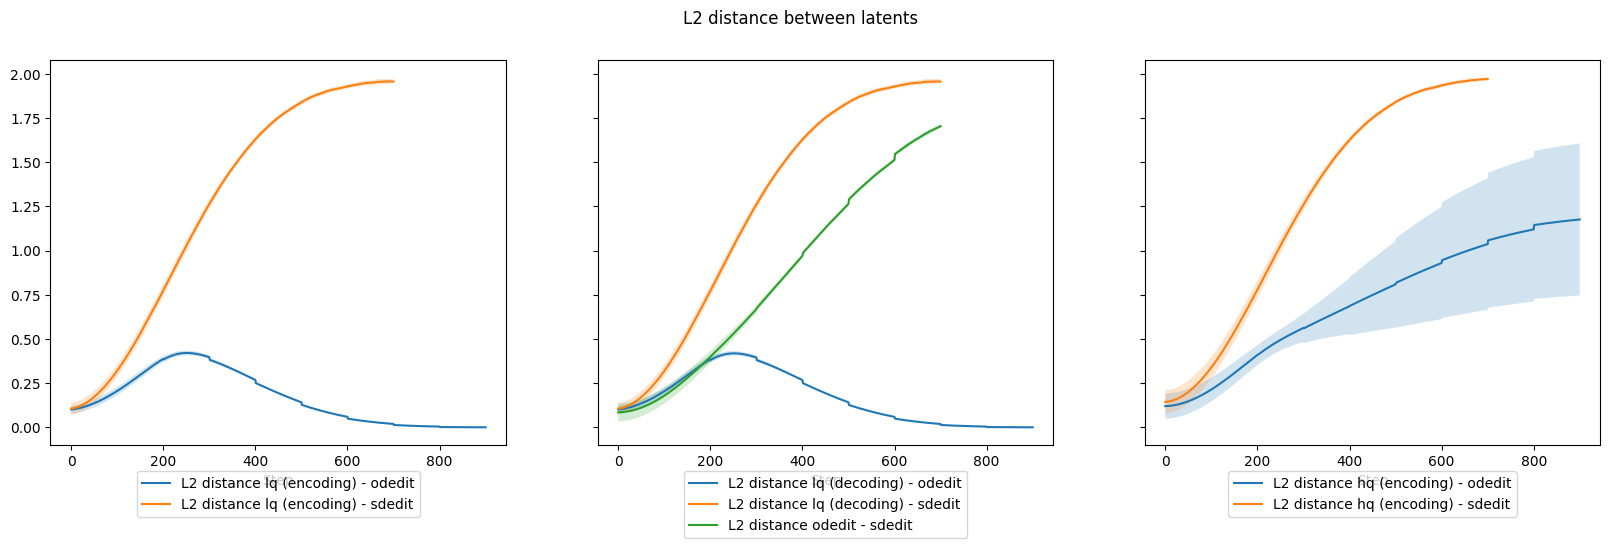

In [260]:
a = []
b = []
c = []
d = []
e = []
f = []
g = []


for i in range(20):
    (_, latent_codes, _, _, _, _) = encoding_ddim_results[i]
    (_, decoded_latent_codes, _, _, _, _) = decoding_ddim_results[i]
    (_, _, _, _, _, _, langevin_decoded_codes) = odedit_results[i]
    (_, hq_latent_codes, _, _, _, _) = hq_encodings[i]
    (_, sdedit_latent_codes) = sdedit_results[i]
    
    
    # calculate L2 distance between source and generated
    list_distances = [((source-generated)**2).mean().item() for source, generated in zip(latent_codes, langevin_decoded_codes[::-1])]
    list_distances_decoded = [((source-generated)**2).mean().item() for source, generated in zip(decoded_latent_codes[::-1], langevin_decoded_codes[::-1])]
    a.append(list_distances)
    b.append(list_distances_decoded)
    
    # calculate L2 distance between target and generated
    list_distances_to_hq = [((target.cpu()-generated.cpu())**2).mean().item() for target, generated in zip(langevin_decoded_codes[::-1], hq_latent_codes)]
    c.append(list_distances_to_hq)

    # calculate L2 distance between source and generated
    list_distances_sde = [((source-generated)**2).mean().item() for source, generated in zip(latent_codes, sdedit_latent_codes[::-1])]
    list_distances_decoded_sde = [((source-generated)**2).mean().item() for source, generated in zip(decoded_latent_codes[::-1], sdedit_latent_codes[::-1])]
    d.append(list_distances_sde)
    e.append(list_distances_decoded_sde)
    
    # calculate L2 distance between target and generated
    list_distances_to_hq_sde = [((target.cpu()-generated.cpu())**2).mean().item() for target, generated in zip(sdedit_latent_codes[::-1], hq_latent_codes)]
    f.append(list_distances_to_hq_sde)
    
    list_distances_ode_sde = [((target-generated)**2).mean().item() for target, generated in zip(sdedit_latent_codes[::-1], langevin_decoded_codes[::-1])]
    g.append(list_distances_ode_sde)
    
    


# L2 distance 
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plot_timeseries(a, axs[0], "L2 distance lq (encoding) - odedit")
plot_timeseries(d, axs[0], "L2 distance lq (encoding) - sdedit")

# axs[0].plot(list_distances, label="L2 distance lq (encoding) - odedit")
# axs[0].plot(list_distances_sde, label="L2 distance lq (encoding) - sdedit")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

plot_timeseries(b, axs[1], "L2 distance lq (decoding) - odedit")
plot_timeseries(e, axs[1], "L2 distance lq (decoding) - sdedit")
plot_timeseries(g, axs[1], "L2 distance odedit - sdedit")

# axs[1].plot(list_distances_decoded, label="L2 distance lq (decoding) - odedit")
# axs[1].plot(list_distances_decoded_sde, label="L2 distance lq (decoding) - sdedit")
# axs[1].plot(list_distances_ode_sde, label="L2 distance odedit - sdedit")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

plot_timeseries(c, axs[2], "L2 distance hq (encoding) - odedit")
plot_timeseries(f, axs[2], "L2 distance hq (encoding) - sdedit")

# axs[2].plot(list_distances_to_hq, label="L2 distance hq (encoding) - odedit")
# axs[2].plot(list_distances_to_hq_sde, label="L2 distance hq (encoding) - sdedit")
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))

fig.suptitle("L2 distance between latents")
plt.show()

In [ ]:
for liste, t in zip(list_of_mean_eps_langevin, list(range(1,1000,100))[::-1]):
    plt.plot(liste, label = f"t = {t}")
    
plt.title("Mean of noise in Langevin updates")
plt.legend()
plt.show()

In [ ]:
for liste, t in zip(list_of_stds_eps_langevin, list(range(1,1000,100))[::-1]):
    plt.plot(liste, label = f"t = {t}")
    
plt.title("Std of noise in Langevin updates")
plt.legend()
plt.show()

# Qualitative results

In [ ]:
samples_tensor = torch.tensor([imshow(x, show=False, transpose=False) for x in samples_unpacked + sdedit_results + odedit_results])

plot_samples_grid(
    samples_tensor,
    title='Samples Visualization',
    rows_texts=['HQ Samples', 'LQ Samples'] + [f"SDEdit (steps={x})" for x in sdedit_steps] + [f"ODEdit (steps={x[0]}, epsilon={x[1]})" for x in odedit_steps],
    cols_texts=[f"Sample {i}" for i in indices],
    figsize=(50, 30)
)

In [ ]:
from IPython.display import Markdown

for i, (hq_sample, lq_sample) in enumerate(zip(hq_samples, lq_samples)):
    display(Markdown(f"### Sample {indices[i]}"))
    play_audio(hq_sample, label="HQ Sample")
    play_audio(lq_sample, label="LQ Sample")
    
    for j, steps in enumerate(sdedit_steps):
        play_audio(sdedit_results[j*len(hq_samples) + i].squeeze(dim=0), label=f"SDEdit (steps={steps})")
        
    for j, (steps, epsilon) in enumerate(odedit_steps):
        play_audio(odedit_results[j*len(hq_samples) + i].squeeze(dim=0), label=f"ODEdit (steps={steps}, epsilon={epsilon} )")

# Metrics

In [20]:
from itertools import chain
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

dataset = AudioDatasetExtended(cfg)
dataset.eq_mode = "random"
dataset.change_subset("test")

set_seed(dataset, 0)

indices = np.random.choice(len(dataset), 200)
samples = [dataset[i] for i in indices]
samples_unpacked = [x[0] for x in samples] + [x[1] for x in samples]

hq_samples = [torch.tensor(x[0]) for x in samples]
lq_samples = [torch.tensor(x[1]) for x in samples]

In [ ]:
list_images = lq_samples
list_enhanced_sde = {}


sample_step = 1
betas = torch.tensor(diffusion.betas)
num_timesteps = diffusion.num_timesteps
logvar = np.log(np.maximum(diffusion.posterior_variance, 1e-20))


noise_levels=list(range(500,700,700))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with tqdm(total=len(noise_levels) * len(list_images)) as pbar:
        for total_noise_levels in noise_levels:
            list_enhanced_sde[total_noise_levels] = []
            for img in list_images:
                new_img_tensor = img.to(device)
                sde_enhanced = SDEditing(new_img_tensor, betas, logvar, model, sample_step, total_noise_levels, n=1, show=False)
                list_enhanced_sde[total_noise_levels].append(sde_enhanced[0].to('cpu'))
                pbar.update(1)
                
sdedit_steps = list(list_enhanced_sde.keys())
sdedit_results = list(chain.from_iterable(list_enhanced_sde.values()))

In [ ]:
list_images = lq_samples

steps = 10
epsilons = [1e-5, 1e-6, 5e-7, 1e-7]
epsilons = [5e-6, 1e-7]
noise_levels = list(range(500,1000,300))
number_of_sample = 1
power = 0.5

list_enhanced_ode = {}
results_odedit = []

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with tqdm(total=len(noise_levels) * len(epsilons) * len(list_images)) as pbar:
        for i, img in enumerate(list_images):
            latent = encoding_ddim(img, model, noise_levels[-1], alphas_cumprod, show_intermediate=False, show_final=False)
            list_enhanced_ode[i] = []
            
            for noise, epsilon in product(noise_levels, epsilons):

                result = ODEditing(
                    latent[1],
                    model,
                    list(range(1,noise,100))[::-1],
                    alphas_cumprod,
                    steps=steps,
                    epsilon=epsilon,
                    number_of_sample=number_of_sample,
                    power=power,
                    show_intermediate=False,
                    show_final=False
                )

                list_enhanced_ode[i].append(result[0].to('cpu'))
                pbar.update(1)
        
odedit_steps = list(list_enhanced_ode.keys())
odedit_results = list(chain.from_iterable(list_enhanced_ode.values()))

In [22]:
psnr = PeakSignalNoiseRatio(data_range=(-1, 1)).to(device)

def get_psnr(pred, device=device):
    values = []
    for hq, lq in zip(hq_samples, pred):
        values.append(psnr(hq.to(device), lq.to(device)).item())
    return values

df = pd.DataFrame(index=indices)
df["LQ Samples"] = get_psnr(lq_samples)

# for i, step in enumerate(sdedit_steps):
#     df[f"SDEdit (steps={step})"] = get_psnr(sdedit_results[i*len(hq_samples):(i+1)*len(hq_samples)])
    
odedit_step_list = list(product(noise_levels, epsilons))
for i, (step, epsilon) in enumerate(odedit_step_list):
    df[f"ODEdit (steps={step}, epsilon={epsilon})"] = get_psnr(odedit_results[i::len(odedit_step_list)])

In [23]:
df_mean = df.mean()
df_mean

LQ Samples                           17.929197
ODEdit (steps=500, epsilon=5e-06)    17.960585
ODEdit (steps=500, epsilon=1e-07)    17.961501
ODEdit (steps=800, epsilon=5e-06)    16.826476
ODEdit (steps=800, epsilon=1e-07)    18.016980
SDEdit (steps=500)                   16.087284
dtype: float64

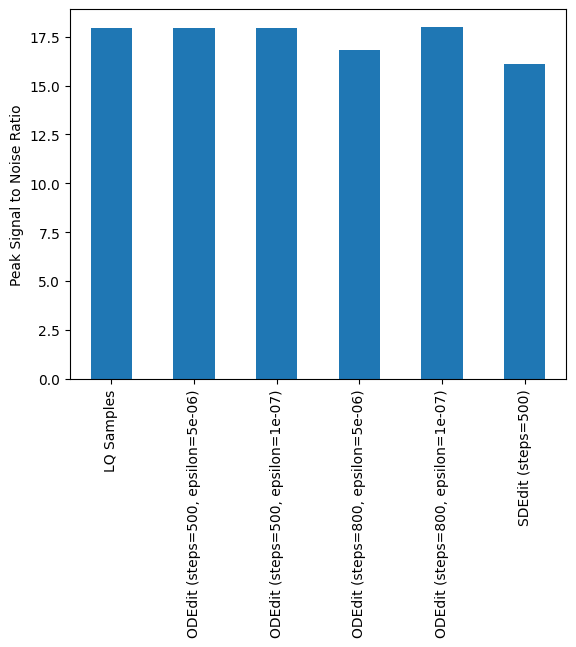

In [24]:
df_mean.plot(kind="bar")
plt.xlabel("")
plt.ylabel("Peak Signal to Noise Ratio");

In [32]:
import soundfile as sf
import tempfile
from clearaudio.transforms import signal
from frechet_audio_distance import FrechetAudioDistance

frechet = FrechetAudioDistance(
    model_name="vggish",
    sample_rate=16000,
    use_pca=False, 
    use_activation=False,
    verbose=False
)

def get_fad(real, pred, device=device):
    with tempfile.TemporaryDirectory() as hq_tmp:
        with tempfile.TemporaryDirectory() as lq_tmp:
            for i, hq in enumerate(hq_samples):
                waveform = torch.tensor(to_audio(hq))
                waveform, _ = signal.resample_signal(waveform, mel.get_sample_rate(), 16000)
                sf.write(hq_tmp + f"/hq_{i}.wav", waveform, 16000, "PCM_24")
            for i, lq in enumerate(lq_samples):
                waveform = torch.tensor(to_audio(lq))
                waveform, _ = signal.resample_signal(waveform, mel.get_sample_rate(), 16000)
                sf.write(lq_tmp + f"/lq_{i}.wav", waveform, 16000, "PCM_24")

            fad_score = frechet.score(hq_tmp, lq_tmp)

            return fad_score

df = pd.Series(dtype=np.float64)
df["LQ Samples"] = get_fad(hq_samples, lq_samples)

# for i, step in enumerate(sdedit_steps):
#     df[f"SDEdit (steps={step})"] = get_fad(hq_samples, sdedit_results[i*len(hq_samples):(i+1)*len(hq_samples)])
    
odedit_step_list = list(product(noise_levels, epsilons))
for i, (step, epsilon) in enumerate(odedit_step_list):
    df[f"ODEdit (steps={step}, epsilon={epsilon})"] = get_fad(hq_samples, odedit_results[i::len(odedit_step_list)])

Using cache found in /home/martorel/.cache/torch/hub/harritaylor_torchvggish_master


In [33]:
df["SDEdit (steps=500)"] = 3.480466
df

LQ Samples                           4.181065
ODEdit (steps=500, epsilon=5e-06)    3.939466
ODEdit (steps=500, epsilon=1e-07)    3.989699
ODEdit (steps=800, epsilon=5e-06)    4.088920
ODEdit (steps=800, epsilon=1e-07)    4.084296
SDEdit (steps=500)                   3.480466
dtype: float64

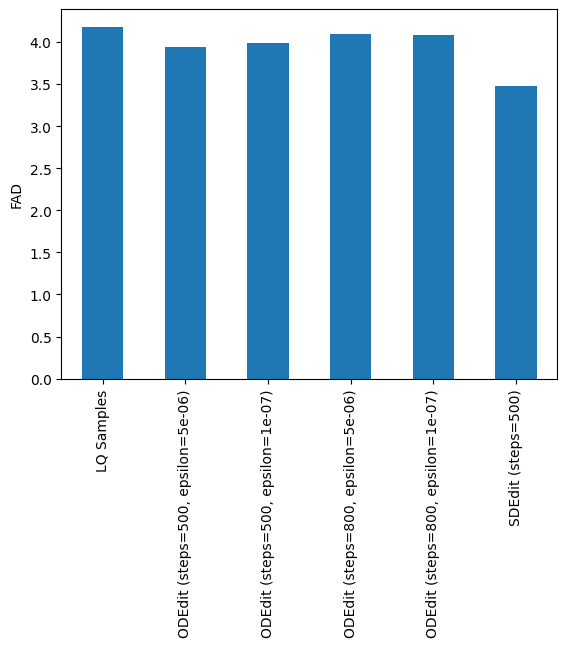

In [34]:
df.plot(kind="bar")
plt.xlabel("")
plt.ylabel("FAD");

In [26]:
from torchmetrics.regression import MeanSquaredError

def get_mse(real, pred, device=device):
    pred = [x.squeeze(dim=1) if len(x.shape) == 4 else x for x in pred]
    
    mse = MeanSquaredError().to(device)
    real = torch.cat(real, dim=0).to(device)
    pred = torch.cat(pred, dim=0).to(device)
    return mse(real, pred).item()

df = pd.Series(dtype=np.float64)
df["HQ Samples"] = get_mse(hq_samples, lq_samples)

for i, step in enumerate(sdedit_steps):
    df[f"SDEdit (steps={step})"] = get_mse(lq_samples, sdedit_results[i*len(hq_samples):(i+1)*len(hq_samples)])
    
odedit_step_list = list(product(noise_levels, epsilons))
for i, (step, epsilon) in enumerate(odedit_step_list):
    df[f"ODEdit (steps={step}, epsilon={epsilon})"] = get_mse(lq_samples, odedit_results[i::len(odedit_step_list)])

In [27]:
df

HQ Samples                           0.090482
ODEdit (steps=500, epsilon=5e-06)    0.024648
ODEdit (steps=500, epsilon=1e-07)    0.000392
ODEdit (steps=800, epsilon=5e-06)    0.079135
ODEdit (steps=800, epsilon=1e-07)    0.001208
SDEdit (steps={500})                 0.099002
dtype: float64

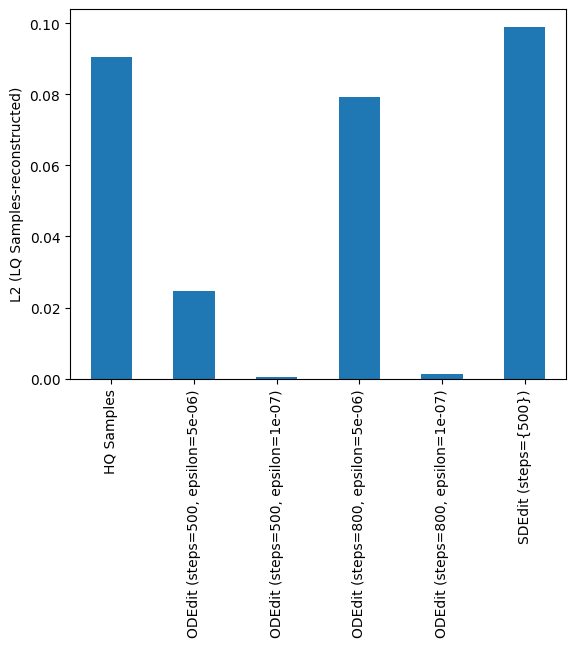

In [28]:
df.plot(kind="bar")
plt.xlabel("")
plt.ylabel("L2 (LQ Samples-reconstructed)");

In [29]:
from torchmetrics.regression import MeanSquaredError

def get_mse(real, pred, device=device):
    pred = [x.squeeze(dim=1) if len(x.shape) == 4 else x for x in pred]
    
    mse = MeanSquaredError().to(device)
    real = torch.cat(real, dim=0).to(device)
    pred = torch.cat(pred, dim=0).to(device)
    return mse(real, pred).item()

df = pd.Series(dtype=np.float64)
df["LQ Samples"] = get_mse(hq_samples, lq_samples)

for i, step in enumerate(sdedit_steps):
    df[f"SDEdit (steps={step})"] = get_mse(hq_samples, sdedit_results[i*len(hq_samples):(i+1)*len(hq_samples)])
    
odedit_step_list = list(product(noise_levels, epsilons))
for i, (step, epsilon) in enumerate(odedit_step_list):
    df[f"ODEdit (steps={step}, epsilon={epsilon})"] = get_mse(hq_samples, odedit_results[i::len(odedit_step_list)])

In [30]:
df

LQ Samples                           0.090482
ODEdit (steps=500, epsilon=5e-06)    0.082927
ODEdit (steps=500, epsilon=1e-07)    0.089870
ODEdit (steps=800, epsilon=5e-06)    0.091106
ODEdit (steps=800, epsilon=1e-07)    0.088465
SDEdit (steps=500)                   0.106240
dtype: float64

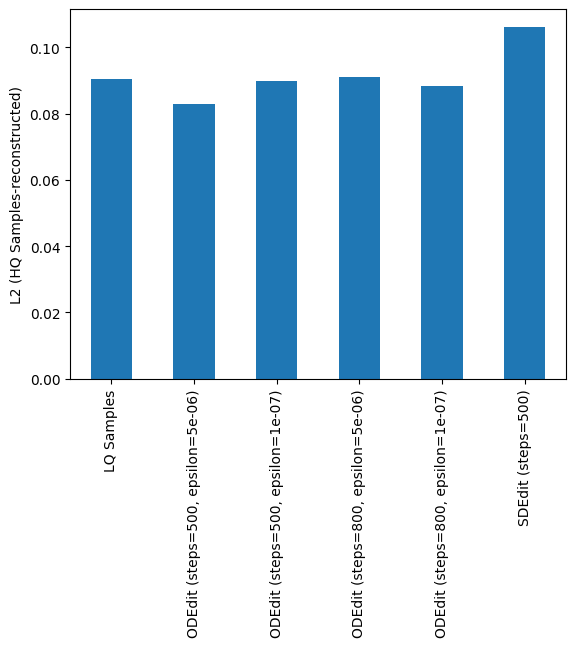

In [31]:
df.plot(kind="bar")
plt.xlabel("")
plt.ylabel("L2 (HQ Samples-reconstructed)");